In [1]:
import jax.numpy as jnp

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
import seaborn as sns

from cartm.model import ContextTopicModel
from cartm.preprocessing import DatasetPreprocessor

This example will guide you through the basic interaction with the model.

## Data preprocessing

First, let's download a sample dataset and preprocess it with `DatasetPreprocessor`.

In [2]:
data = fetch_20newsgroups(data_home='./data/', subset='all').data
print(f'Total number of documents in corpus: {len(data)}')
print(f'Total number of words in corpus: {sum([len(doc.split(' ')) for doc in data])}')

Total number of documents in corpus: 18846
Total number of words in corpus: 5937230


In [3]:
preprocessor = DatasetPreprocessor()
tokenized_data, document_bounds = preprocessor.fit_transform(data)
print(f'Total number of document boundaries in preprocessed corpus: {len(document_bounds)}')
print(f'Total number of tokenized words in preprocessed corpus: {len(tokenized_data)}')

Total number of document boundaries in preprocessed corpus: 18847
Total number of tokenized words in preprocessed corpus: 3450212


The `DatasetPreprocessor` class handles the filtering and tokenizing of the raw data. Its method `fit_transform` learns the vocabulary of the passed corpus of documents and returns tokenized words from corpus as the first return value, and document bounds as the second return value.

By default, `DatasetPreprocessor` removes stopwords, digits and special characters, therefore the total number of tokenized words is less than the number of words in raw corpus. Document boundaries are at the beginning and ending of the document, therefore the number of boundaries is [number_of_documents] + 1.

The returned values from `fit_transform` have jax.numpy.ndarray type, so you can work with them like a normal arrays.

In [4]:
print(f'Number of unique words in the preprocessed corpus: {jnp.max(tokenized_data)}')

Number of unique words in the preprocessed corpus: 107672


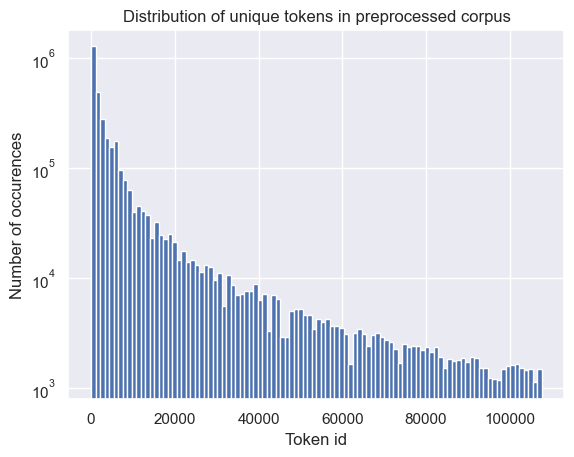

In [5]:
sns.set_theme()

plt.hist(tokenized_data, bins=100)

plt.xlabel('Token id')
plt.ylabel('Number of occurences')
plt.title('Distribution of unique tokens in preprocessed corpus')
plt.yscale('log')
plt.show()

### Accessing vocabulary

You can also access mapping of words to tokens after fitting the preprocessor with data.

In [6]:
vocabulary = preprocessor.vocabulary

for i, (word, token) in enumerate(vocabulary.items()):
    print(f'{word}: {token}')
    if i == 10:
        break

mamatha: 0
devineni: 1
ratnam: 2
mr: 3
andrew: 4
cmu: 5
edu: 6
subject: 7
pen: 8
fan: 9
reaction: 10


## Model training

Having the data preprocessed with `DatasetPreprocessor`, we can fit out model pretty straighforwardly.

Please note that calling `fit` method multiple times in one model will discard all results of the previous training.

In [7]:
topic_model = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)

topic_model.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    verbose=2,
    seed=42,
)

Iteration [1/1000], phi update diff norm: 0.1297
Iteration [2/1000], phi update diff norm: 0.0264
Iteration [3/1000], phi update diff norm: 0.0386
Iteration [4/1000], phi update diff norm: 0.0521
Iteration [5/1000], phi update diff norm: 0.0535
Iteration [6/1000], phi update diff norm: 0.0409
Iteration [7/1000], phi update diff norm: 0.0418
Iteration [8/1000], phi update diff norm: 0.0481
Iteration [9/1000], phi update diff norm: 0.0577
Iteration [10/1000], phi update diff norm: 0.0701
Iteration [11/1000], phi update diff norm: 0.0788
Iteration [12/1000], phi update diff norm: 0.0738
Iteration [13/1000], phi update diff norm: 0.0523
Iteration [14/1000], phi update diff norm: 0.0293
Iteration [15/1000], phi update diff norm: 0.0169
Iteration [16/1000], phi update diff norm: 0.0118
Iteration [17/1000], phi update diff norm: 0.0092
Iteration [18/1000], phi update diff norm: 0.0077
Iteration [19/1000], phi update diff norm: 0.0069
Iteration [20/1000], phi update diff norm: 0.0060
Iteration

The model training stops because the update diff norm becomes too low. This means that the model has converged. You can modify the convergence threshold and max number of iterations.

In [8]:
topic_model_tol = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)

topic_model_tol.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    tol=0.01,
    verbose=2,
    seed=42,
)

Iteration [1/1000], phi update diff norm: 0.1297
Iteration [2/1000], phi update diff norm: 0.0264
Iteration [3/1000], phi update diff norm: 0.0386
Iteration [4/1000], phi update diff norm: 0.0521
Iteration [5/1000], phi update diff norm: 0.0535
Iteration [6/1000], phi update diff norm: 0.0409
Iteration [7/1000], phi update diff norm: 0.0418
Iteration [8/1000], phi update diff norm: 0.0481
Iteration [9/1000], phi update diff norm: 0.0577
Iteration [10/1000], phi update diff norm: 0.0701
Iteration [11/1000], phi update diff norm: 0.0788
Iteration [12/1000], phi update diff norm: 0.0738
Iteration [13/1000], phi update diff norm: 0.0523
Iteration [14/1000], phi update diff norm: 0.0293
Iteration [15/1000], phi update diff norm: 0.0169
Iteration [16/1000], phi update diff norm: 0.0118
Iteration [17/1000], phi update diff norm: 0.0092


In [9]:
topic_model_iter = ContextTopicModel(
    vocab_size=len(preprocessor.vocabulary),
    ctx_len=10,
)

topic_model_iter.fit(
    data=tokenized_data,
    ctx_bounds=document_bounds,
    max_iter=10,
    verbose=2,
    seed=42,
)

Iteration [1/10], phi update diff norm: 0.1297
Iteration [2/10], phi update diff norm: 0.0264
Iteration [3/10], phi update diff norm: 0.0386
Iteration [4/10], phi update diff norm: 0.0521
Iteration [5/10], phi update diff norm: 0.0535
Iteration [6/10], phi update diff norm: 0.0409
Iteration [7/10], phi update diff norm: 0.0418
Iteration [8/10], phi update diff norm: 0.0481
Iteration [9/10], phi update diff norm: 0.0577
Iteration [10/10], phi update diff norm: 0.0701


You can also modify number of topics and other parameters of the model. Refer to the `fit` funciton docs for more info about model training.

## Analysis

After the model is fitted, you can access its parameters and analyse them.

In [10]:
phi_wt = topic_model.phi  # p(w|t)
n_t = topic_model.n_t  # denormalized distribution of topics
print(f'phi matrix type: {type(phi_wt)}, shape: {phi_wt.shape}')
print(f'n_t array type: {type(n_t)}, shape: {n_t.shape}')

phi matrix type: <class 'jaxlib.xla_extension.ArrayImpl'>, shape: (107673, 10)
n_t array type: <class 'jaxlib.xla_extension.ArrayImpl'>, shape: (10,)


### Plot a histogram of a distribution of topics in corpus:

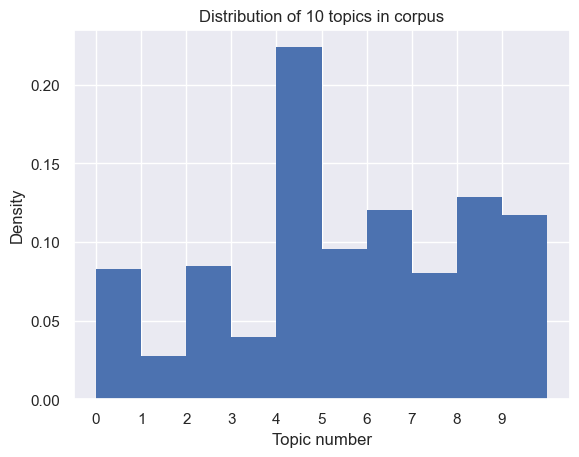

In [11]:
plt.stairs(n_t / n_t.sum(), range(len(n_t) + 1), fill=True)

plt.xticks(range(len(n_t)))
plt.xlabel('Topic number')
plt.ylabel('Density')
plt.title('Distribution of 10 topics in corpus')
plt.show()

### Print top-10 words from each topic:

In [12]:
# find top-10 words with the biggest probability p(w|t) for each topic t
topk = jnp.argsort(phi_wt, axis=0, descending=True)[:10, :].T

# create mapping token -> word from existing mapping word -> token (vocabulary)
reverse_vocab = {value: key for key, value in vocabulary.items()}

for topic_idx, t in enumerate(topk):
    print(f'Topic {topic_idx + 1}:', '\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

Topic 1: line	organization	article	university	apr	edu	distribution	state	usa	ca

Topic 2: ax	max	edu	fi	caltech	frank	uchicago	keith	cco	midway

Topic 3: god	wa	christian	law	say	jesus	believe	word	religion	doe

Topic 4: please	mail	anyone	thanks	know	gov	e	help	nasa	doe

Topic 5: wa	people	one	ha	would	time	year	think	know	like

Topic 6: x	window	file	system	program	image	software	version	use	graphic

Topic 7: edu	c	r	w	g	f	p	b	q	v

Topic 8: com	subject	writes	david	edu	uk	ac	reply	john	mark

Topic 9: would	make	use	one	question	key	doe	may	system	also

Topic 10: drive	game	get	car	go	back	wa	one	power	new

